## 5. WOFOST Crop Simulation Model

In [1]:
import numpy as np
import os, sys, math, yaml
import datetime as dt
from dateutil.parser import parse
import pandas as pd
#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
import json

# from pcse.fileinput import YAMLAgroManagementReader
from pcse.util import WOFOST71SiteDataProvider, WOFOST72SiteDataProvider
# from pcse.fileinput import PCSEFileReader

import pcse

from pcse.models import Wofost72_PP, Wofost72_WLP_FD
from pcse.fileinput import YAMLCropDataProvider

from pcse.util import WOFOST72SiteDataProvider, DummySoilDataProvider
from pcse.base import ParameterProvider
from pcse.engine import Engine
from pcse.fileinput.csvweatherdataprovider import CSVWeatherDataProvider

Platform not recognized, using system temp directory for PCSE settings.
Platform not recognized, using system temp directory for PCSE settings.


In [3]:
def prepareWeather(in_fname: str):
    """
    Read weather file, after convert to WOFOST CSV format and 
    read into memory to PCSE weather Class
    
    in: in_fname (str) - path to csv file with weather time-series
    """
    # read weather time-series
    weather_df = pd.read_csv(in_fname)
    # future name
    path_to_save_csv_file = './wofost_weather.csv'
    # pattern for WOFOST format
    text = open('./pattern.csv', "r")
    dictReplace = {
        "1111": "37.0",
        "2222": "51.5",
        "3333": "210.05", # m
        "4444": "0.172729",
        "5555": "0.565318",
    }
    for key, value in dictReplace.items():
        text = "".join([i for i in text]).replace(key, str(value))
    x = open(path_to_save_csv_file, "w")
    x.writelines(text)
    x.close()
    weather_df.to_csv(
        path_to_save_csv_file, mode="a", header=False, index=False, na_rep='NaN'
    )
    weather = CSVWeatherDataProvider(path_to_save_csv_file)
    return weather

In [39]:
def run_wofost(weather, 
              sowing_date:str,
              harvesting_date:str,
              crop_end_type: str = 'maturity',
              crop_name:str = 'sugarbeet',
              crop_variety:str = 'Sugarbeet_603', 
              models: list = ['FLD', 'PP'])-> dict:

    """
        Prepare parameters: meteo, agrotechnology and run WOFOST simulation in PP and FLD modes.   

        Parameters
        ----------
        crop_name: str
            Crop name fow WOFOST model
        crop_variety: str
            Crop variety fow WOFOST crop 
        sowing_date: str
            Date of crop sowing, ex. %Y-%m-%d
        harvest_date: str 
        - optional
            Date of crop harvest, ex. %Y-%m-%d
            
        Returns
        -------
        results: dict 
            dict with PCSE objects: cropd, wdp
            if run_similation: True 
                return computed default yield
        To-Do
        -----


        Example
        -------

    """
    cropd = YAMLCropDataProvider(repository="https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/master/")
    # Some site parameters
    sited = WOFOST71SiteDataProvider(WAV=50, SMLIM=0.7)

    soild = DummySoilDataProvider() # TO - DO: add soilgrids here

    soild['SMW'] = 0.15
    soild['SMFCF'] = 0.3
    soild['SM0'] = 0.566 

    _campaign_start_date_dt = parse(sowing_date) -  dt.timedelta(days=5)
    campaign_start_date = dt.datetime.strftime(_campaign_start_date_dt, format='%Y-%m-%d')

    max_duration = 300

    # Here we define the agromanagement for crop
    agro_yaml = f"""
    - {campaign_start_date}:
        CropCalendar:
            crop_name: {crop_name}
            variety_name: {crop_variety}
            crop_start_date: {sowing_date}
            crop_start_type: emergence
            crop_end_date: {harvesting_date}
            crop_end_type: {crop_end_type}
            max_duration: {max_duration}
        TimedEvents: null
        StateEvents: null
    """
    agro = yaml.safe_load(agro_yaml)

    firstkey = list(agro[0])[0]
    cropcalendar = agro[0][firstkey]['CropCalendar'] 

    cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])

    params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

    defualtCropYield={}
    
    modelDict = {'FLD':Wofost72_WLP_FD, 
                'PP': Wofost72_PP}
    for model_type in ['FLD']:
        params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
        model_runner = modelDict[model_type](params, weather, agro)
        model_runner.run_till_terminate()
        r = model_runner.get_output()
        defualtCropYield[model_type]=r
        del model_runner
    del weather
    return defualtCropYield


def getCropCalendar(crop:str,
                    year:str)->dict:
    _df = df_agrotech.copy()
    _df.iloc[:, 1:] = _df.iloc[:, 1:].applymap(lambda x : x.replace('2021', year))
    mask = _df['crop']==crop
    return {'plant_day': _df.loc[mask, 'plant_day'].values[0],
            'harvest_day': _df.loc[mask, 'harvest_day'].values[0]}

In [40]:
cropsDict = {'barley':'Spring_barley_301', 
            'soybean':'Soybean_901',
            'sunflower':'Sunflower_1101',
            'maize':'Grain_maize_201', 
            'sugarbeet':'Sugarbeet_603'}
            
df_agrotech = pd.read_csv('./agrotechnology.csv', index_col=0)

df_agrotech = df_agrotech.reset_index(drop=True)

cols = ['crop', 'year', 'WOFOST_FLD']
crops = ['barley', 'soybean', 'sugarbeet']

## Real

In [41]:
real_weather = prepareWeather('./predicted_weather/real.csv')
real_df = pd.DataFrame(columns=cols)

for crop in crops:
    for year in range(2015,2020):
        cropCal = getCropCalendar(crop, str(year))
        crop_model_yield = run_wofost(weather = real_weather,
                  sowing_date = cropCal['plant_day'],
                  harvesting_date = cropCal['harvest_day'],
                  crop_name = crop,
                  crop_variety = cropsDict[crop],
                  crop_end_type='harvest')
        water_limited_df = pd.DataFrame(crop_model_yield['FLD'])
        water_limited_yield = crop_model_yield['FLD'][-1]['TWSO']
    
        # potential_yield_df = pd.DataFrame(crop_model_yield['PP'])
        # potential_yield = crop_model_yield['PP'][-1]['TWSO']
        real_df.loc[len(real_df)] = [crop, year, water_limited_yield]


In [42]:
real_df

,crop,year,WOFOST_FLD
0,barley,2015,6901.006215
1,barley,2016,6768.874691
2,barley,2017,7179.128216
3,barley,2018,6905.136501
4,barley,2019,6924.326079
5,soybean,2015,3797.050240
6,soybean,2016,3554.163833
7,soybean,2017,3117.730994
8,soybean,2018,3522.569167
9,soybean,2019,3733.773347


## Baseline

In [44]:
baseline_weather = prepareWeather('./predicted_weather/baseline.csv')
baseline_df = pd.DataFrame(columns=cols)

for crop in crops:
    for year in range(2015,2020):
        cropCal = getCropCalendar(crop, str(year))
        crop_model_yield = run_wofost(weather = baseline_weather,
                  sowing_date = cropCal['plant_day'],
                  harvesting_date = cropCal['harvest_day'],
                  crop_name = crop,
                  crop_variety = cropsDict[crop],
                  crop_end_type='harvest')
        water_limited_df = pd.DataFrame(crop_model_yield['FLD'])
        water_limited_yield = crop_model_yield['FLD'][-1]['TWSO']
    
        # potential_yield_df = pd.DataFrame(crop_model_yield['PP'])
        # potential_yield = crop_model_yield['PP'][-1]['TWSO']
        baseline_df.loc[len(baseline_df)] = [crop, year, water_limited_yield]


In [45]:
baseline_df

,crop,year,WOFOST_FLD
0,barley,2015,6960.738151
1,barley,2016,6950.637895
2,barley,2017,6960.738151
3,barley,2018,6960.738151
4,barley,2019,6960.738151
5,soybean,2015,3298.675377
6,soybean,2016,3286.668643
7,soybean,2017,3298.675377
8,soybean,2018,3298.675377
9,soybean,2019,3298.675377


## Prophet

In [46]:
prophet_weather = prepareWeather('./predicted_weather/prophet.csv')
prophet_df = pd.DataFrame(columns=cols)

for crop in crops:
    for year in range(2015,2020):
        cropCal = getCropCalendar(crop, str(year))
        crop_model_yield = run_wofost(weather = prophet_weather,
                  sowing_date = cropCal['plant_day'],
                  harvesting_date = cropCal['harvest_day'],
                  crop_name = crop,
                  crop_variety = cropsDict[crop],
                  crop_end_type='harvest')
        water_limited_df = pd.DataFrame(crop_model_yield['FLD'])
        water_limited_yield = crop_model_yield['FLD'][-1]['TWSO']
    
        # potential_yield_df = pd.DataFrame(crop_model_yield['PP'])
        # potential_yield = crop_model_yield['PP'][-1]['TWSO']
        prophet_df.loc[len(prophet_df)] = [crop, year, water_limited_yield]

In [49]:
prophet_df

,crop,year,WOFOST_FLD
0,barley,2015,5985.519155
1,barley,2016,5750.581149
2,barley,2017,5511.087088
3,barley,2018,5269.121113
4,barley,2019,5017.517866
5,soybean,2015,2579.873486
6,soybean,2016,2440.034560
7,soybean,2017,2327.906895
8,soybean,2018,2213.189817
9,soybean,2019,2104.672380


## Neural Prophet

In [48]:
nn_prophet = pd.read_csv('./predicted_weather/neural_prophet.csv')
nn_prophet['RAIN'][nn_prophet['RAIN'] < 0] = 0
nn_prophet['VAP'][nn_prophet['VAP'] < 0.06] = 0.06
nn_prophet.to_csv('./predicted_weather/neural_prophet.csv', index=False)

/var/folders/1f/xyznj37x1n337kxt0v5533rw0000gn/T/ipykernel_12060/2571223748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nn_prophet['RAIN'][nn_prophet['RAIN'] < 0] = 0
/var/folders/1f/xyznj37x1n337kxt0v5533rw0000gn/T/ipykernel_12060/2571223748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nn_prophet['VAP'][nn_prophet['VAP'] < 0.06] = 0.06


In [50]:
nn_prophet_weather = prepareWeather('./predicted_weather/neural_prophet.csv')
nn_prophet_df = pd.DataFrame(columns=cols)

for crop in crops:
    for year in range(2015,2020):
        cropCal = getCropCalendar(crop, str(year))
        crop_model_yield = run_wofost(weather = nn_prophet_weather,
                  sowing_date = cropCal['plant_day'],
                  harvesting_date = cropCal['harvest_day'],
                  crop_name = crop,
                  crop_variety = cropsDict[crop],
                  crop_end_type='harvest')
        water_limited_df = pd.DataFrame(crop_model_yield['FLD'])
        water_limited_yield = crop_model_yield['FLD'][-1]['TWSO']
    
        # potential_yield_df = pd.DataFrame(crop_model_yield['PP'])
        # potential_yield = crop_model_yield['PP'][-1]['TWSO']
        nn_prophet_df.loc[len(nn_prophet_df)] = [crop, year, water_limited_yield]

In [51]:
nn_prophet_df

,crop,year,WOFOST_FLD
0,barley,2015,4086.204350
1,barley,2016,3309.342045
2,barley,2017,2696.925647
3,barley,2018,2318.215473
4,barley,2019,2161.522557
5,soybean,2015,1670.479370
6,soybean,2016,1358.295995
7,soybean,2017,1091.243718
8,soybean,2018,907.785398
9,soybean,2019,823.126987


## Plot weather

In [53]:
nn_prophet

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH
0,20150101,3001.484131,-10.862907,-4.594908,0.249301,3.698900,1.168701,NaN
1,20150102,3077.255859,-11.069485,-4.773834,0.240111,3.706066,0.952799,NaN
2,20150103,3096.719971,-11.095245,-4.694977,0.252143,3.695179,1.125625,NaN
3,20150104,3141.643311,-11.347363,-4.893229,0.247996,3.692922,1.151343,NaN
4,20150105,3028.657227,-11.571760,-5.004087,0.247710,3.693436,1.105348,NaN
...,...,...,...,...,...,...,...,...
1821,20191227,2924.378906,-10.304070,-2.425756,0.060000,3.611044,0.000000,NaN
1822,20191228,2933.844727,-10.345835,-2.364422,0.060000,3.597232,0.000000,NaN
1823,20191229,2969.407227,-10.614323,-2.580894,0.060000,3.591998,0.000000,NaN
1824,20191230,2847.631348,-10.855516,-2.710732,0.060000,3.589518,0.000000,NaN


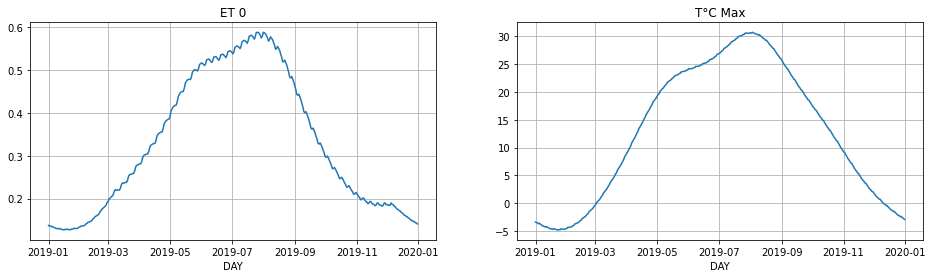

In [55]:
df_weather = pd.DataFrame(nn_prophet_weather.export())
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
df_weather.set_index('DAY')['ET0'][-365:].plot(ax=ax1, label='ET0')
df_weather.set_index('DAY')['TMAX'][-365:].plot(ax=ax2, label='T MAX')
ax1.set_title('ET 0')
ax1.grid()
ax2.set_title('T°C Max')
ax2.grid()

## Plot crop yield

In [56]:
def getPlot(df:pd.DataFrame):
    df = df.set_index("day")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
    for var, ax in zip(["DVS", "TWSO", "LAI", "SM"], axes.flatten()):
        ax.plot_date(df.index, df[var], 'b-')
        ax.set_title(var)
        ax.grid()
    fig.autofmt_xdate()

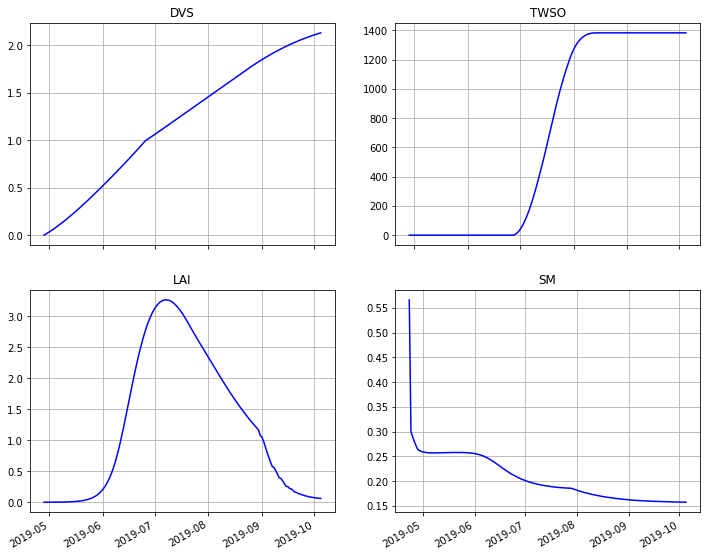

In [57]:
getPlot(water_limited_df)

## Append to CSV file 

In [12]:
from csv import writer 

def append_to_csv(fname: str, row_to_write: list) -> None:
    with open(fname, mode='a+', newline='') as write_object:
        csv_writer = writer(write_object)
        csv_writer.writerow(row_to_write)


In [15]:
pd.DataFrame(columns=cols).to_csv('interval_data.csv', index=False)

In [18]:
cols

['crop', 'year', 'WOFOST_FLD']

In [22]:
x = 6000.
x+np.random.normal(loc=0, scale=1000)

5492.853737130209

In [32]:
dict_to_write = {'crop':'barley', 'year':2020, 'WOFOST_FLD':3234}

In [38]:
df_to_write  =pd.DataFrame.from_dict(dict_to_write, orient='record')
df_to_write


ValueError: only recognize index or columns for orient

## End